In [32]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [33]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [34]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [35]:
content_image = load_image('./Images/color/53.jpg')
style_image = load_image('./Images/styled/style_image1.png')

In [36]:
content_image.shape

TensorShape([1, 150, 150, 3])

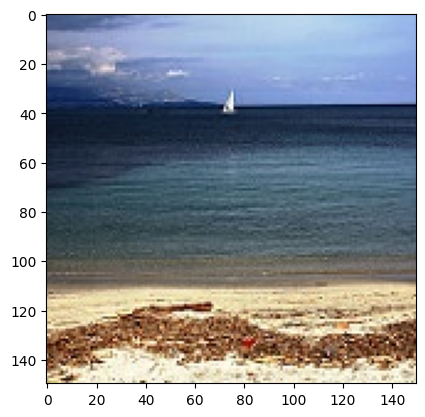

In [37]:
plt.imshow(np.squeeze(content_image))
plt.show()

In [38]:
style_image.shape

TensorShape([1, 599, 757, 3])

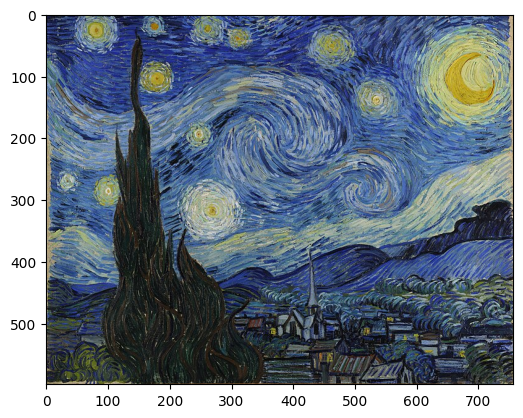

In [39]:
plt.imshow(np.squeeze(style_image))
plt.show()

In [40]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

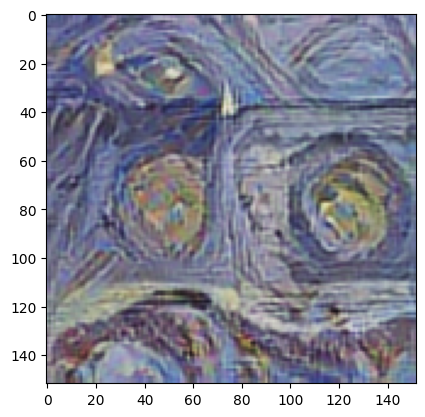

In [41]:
plt.imshow(np.squeeze(stylized_image))
plt.show()

In [11]:
cv2.imwrite('generated_img.jpg', cv2.cvtColor(np.squeeze(stylized_image)*255, cv2.COLOR_BGR2RGB))

True

You can even change the content images and style images according to your likes and download the stylised image from the outputs sections after running the whole script. Thank you!!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from torch.utils.data import Dataset

# Define Generator model with adjusted padding
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),  # Keep padding to maintain dimensions
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator model (unchanged)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define CycleGAN (unchanged)
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.G_AB = Generator()  # Generator from A to B
        self.G_BA = Generator()  # Generator from B to A
        self.D_A = Discriminator()  # Discriminator for A
        self.D_B = Discriminator()  # Discriminator for B

    def forward(self, real_A, real_B):
        fake_B = self.G_AB(real_A)
        cycled_A = self.G_BA(fake_B)
        
        fake_A = self.G_BA(real_B)
        cycled_B = self.G_AB(fake_A)
        
        return fake_A, fake_B, cycled_A, cycled_B

# Function to save model checkpoint
def save_checkpoint(epoch, cycle_gan, optimizer_G, optimizer_D_A, optimizer_D_B, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'cycle_gan_state_dict': cycle_gan.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
    }, os.path.join(checkpoint_dir, f"cycle_gan_epoch_{epoch}.pth"))

# Function to load model checkpoint
def load_checkpoint(cycle_gan, optimizer_G, optimizer_D_A, optimizer_D_B, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    cycle_gan.load_state_dict(checkpoint['cycle_gan_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])
    return checkpoint['epoch']

# Early Stopping class definition
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        """
        Args:
            patience (int): Số lượng epoch không cải thiện trước khi dừng.
            min_delta (float): Mức cải thiện nhỏ nhất cần thiết để được xem là cải thiện.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0  # reset nếu có cải thiện
        else:
            self.counter += 1  # không cải thiện -> tăng counter
            if self.counter >= self.patience:
                self.early_stop = True

# Training function with Early Stopping
def train(cycle_gan, dataloader_A, dataloader_B, num_epochs=200, lr=0.0002, checkpoint_dir="checkpoints", resume=False, patience=5, max_steps=None):
    optimizer_G = optim.Adam(list(cycle_gan.G_AB.parameters()) + list(cycle_gan.G_BA.parameters()), lr=lr)
    optimizer_D_A = optim.Adam(cycle_gan.D_A.parameters(), lr=lr)
    optimizer_D_B = optim.Adam(cycle_gan.D_B.parameters(), lr=lr)

    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()

    early_stopping = EarlyStopping(patience=patience)

    start_epoch = 0
    if resume:
        checkpoint_path = os.path.join(checkpoint_dir, f"cycle_gan_epoch_{start_epoch}.pth")
        start_epoch = load_checkpoint(cycle_gan, optimizer_G, optimizer_D_A, optimizer_D_B, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):
        total_loss_G = 0  # Initialize generator loss for each epoch

        for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
            real_A, real_B = real_A[0].to(device), real_B[0].to(device)

            # Train the Generators
            optimizer_G.zero_grad()
            fake_B, fake_A, cycled_A, cycled_B = cycle_gan(real_A, real_B)

            # Calculate losses
            loss_G_A = criterion_GAN(cycle_gan.D_B(fake_B), torch.ones_like(cycle_gan.D_B(fake_B)))
            loss_G_B = criterion_GAN(cycle_gan.D_A(fake_A), torch.ones_like(cycle_gan.D_A(fake_A)))
            loss_cycle = criterion_cycle(cycled_A, real_A) + criterion_cycle(cycled_B, real_B)

            loss_G = loss_G_A + loss_G_B + 10 * loss_cycle
            loss_G.backward()
            optimizer_G.step()
            total_loss_G += loss_G.item()  # Sum generator loss

            # Train Discriminator A
            optimizer_D_A.zero_grad()
            loss_D_A = criterion_GAN(cycle_gan.D_A(real_A), torch.ones_like(cycle_gan.D_A(real_A))) + \
                        criterion_GAN(cycle_gan.D_A(fake_A.detach()), torch.zeros_like(cycle_gan.D_A(fake_A.detach())))
            loss_D_A.backward()
            optimizer_D_A.step()

            # Train Discriminator B
            optimizer_D_B.zero_grad()
            loss_D_B = criterion_GAN(cycle_gan.D_B(real_B), torch.ones_like(cycle_gan.D_B(real_B))) + \
                        criterion_GAN(cycle_gan.D_B(fake_B.detach()), torch.zeros_like(cycle_gan.D_B(fake_B.detach())))
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 20 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader_A)}], "
                      f"Loss G: {loss_G.item()}, Loss D_A: {loss_D_A.item()}, Loss D_B: {loss_D_B.item()}")

            # Stop after reaching max_steps if provided
            if max_steps and i >= max_steps - 1:
                break

        avg_loss_G = total_loss_G / len(dataloader_A)  # Calculate average generator loss
        print(f"Epoch [{epoch}/{num_epochs}], Avg Generator Loss: {avg_loss_G}")

        # Check for early stopping
        early_stopping(avg_loss_G)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

        # Save images for visualization
        if epoch % 10 == 0:
            save_image(fake_A, f"fake_A_epoch_{epoch}.png")
            save_image(fake_B, f"fake_B_epoch_{epoch}.png")

        # Save checkpoint after each epoch
        save_checkpoint(epoch, cycle_gan, optimizer_G, optimizer_D_A, optimizer_D_B, checkpoint_dir)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom dataset (unchanged)
class CustomDataset(Dataset):
    def __init__(self, folder_A, folder_B, transform=None):
        self.folder_A = folder_A
        self.folder_B = folder_B
        self.transform = transform
        
        self.images_A = [os.path.join(folder_A, img) for img in os.listdir(folder_A) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.images_B = [os.path.join(folder_B, img) for img in os.listdir(folder_B) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        random.shuffle(self.images_A)
        random.shuffle(self.images_B)

    def __len__(self):
        return min(len(self.images_A), len(self.images_B))

    def __getitem__(self, idx):
        img_A = Image.open(self.images_A[idx])
        img_B = Image.open(self.images_B[idx])
        
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

# Set paths (unchanged)
normalPhoto = "./Images/Monet2Photo/testB"
stylePhoto = "./Images/Monet2Photo/testA"

# Prepare DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Initialize CustomDataset
dataset_A = CustomDataset(stylePhoto, normalPhoto, transform=transform)
dataset_B = CustomDataset(normalPhoto, stylePhoto, transform=transform)

dataloader_A = torch.utils.data.DataLoader(dataset_A, batch_size=1, shuffle=True)
dataloader_B = torch.utils.data.DataLoader(dataset_B, batch_size=1, shuffle=True)

# Initialize model and train
cycle_gan = CycleGAN().to(device)
train(cycle_gan, dataloader_A, dataloader_B, num_epochs=2, resume=False, max_steps=100)


Epoch [0/2], Step [0/121], Loss G: 7.896617889404297, Loss D_A: 0.503256618976593, Loss D_B: 0.49963027238845825
Epoch [0/2], Step [100/121], Loss G: 2.945408821105957, Loss D_A: 0.11728903651237488, Loss D_B: 0.4535004496574402
Epoch [0/2], Avg Generator Loss: 4.171503020712167
Epoch [1/2], Step [0/121], Loss G: 4.125457763671875, Loss D_A: 0.000567261187825352, Loss D_B: 0.464537650346756
Epoch [1/2], Step [100/121], Loss G: 1.9007011651992798, Loss D_A: 0.941369354724884, Loss D_B: 0.6161714792251587
Epoch [1/2], Avg Generator Loss: 2.688551971735048


In [11]:
import torch
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os
import torch.nn as nn

# Định nghĩa Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)

# Định nghĩa Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Định nghĩa CycleGAN
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.G_AB = Generator()  # Generator từ A sang B
        self.G_BA = Generator()  # Generator từ B sang A
        self.D_A = Discriminator()  # Discriminator cho A
        self.D_B = Discriminator()  # Discriminator cho B

# Hàm tải mô hình
def load_model(checkpoint_path, device):
    cycle_gan = CycleGAN().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Kiểm tra các khóa trong checkpoint
    print("Checkpoint keys:", checkpoint.keys())  # In ra các khóa cấp cao
    if 'cycle_gan_state_dict' in checkpoint:
        print("CycleGAN state dict keys:", checkpoint['cycle_gan_state_dict'].keys())  # In ra các khóa trong cycle_gan_state_dict

    # Tải các state dict
    try:
        cycle_gan.G_AB.load_state_dict(checkpoint['cycle_gan_state_dict']['G_AB'])
    except KeyError:
        print("Warning: 'G_AB' not found in the checkpoint. Available keys:", checkpoint['cycle_gan_state_dict'].keys())
    
    try:
        cycle_gan.G_BA.load_state_dict(checkpoint['cycle_gan_state_dict']['G_BA'])
    except KeyError:
        print("Warning: 'G_BA' not found in the checkpoint. Available keys:", checkpoint['cycle_gan_state_dict'].keys())
        
    try:
        cycle_gan.D_A.load_state_dict(checkpoint['D_A_state_dict'])
    except KeyError:
        print("Warning: 'D_A' not found in the checkpoint.")
    
    try:
        cycle_gan.D_B.load_state_dict(checkpoint['D_B_state_dict'])
    except KeyError:
        print("Warning: 'D_B' not found in the checkpoint.")
    
    cycle_gan.eval()  # Đặt mô hình ở chế độ đánh giá
    return cycle_gan

# Hàm biến đổi hình ảnh
def transform_image(image_path, model, device):
    # Tải và tiền xử lý hình ảnh
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa cho đầu ra Tanh
    ])
    
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)  # Thêm kích thước batch và chuyển sang thiết bị

    # Chạy generator để biến đổi hình ảnh
    with torch.no_grad():
        fake_image = model.G_AB(img)  # Biến đổi từ kiểu A sang kiểu B

    return fake_image

# Hàm lưu hình ảnh đầu ra
def save_output_image(tensor_image, output_path):
    # Chuyển đổi tensor về hình ảnh
    tensor_image = (tensor_image.squeeze(0) * 0.5 + 0.5).clamp(0, 1)  # Tái định hình về [0, 1]
    save_image(tensor_image, output_path)

# Đặt thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải mô hình đã huấn luyện
checkpoint_path = "./checkpoints/cycle_gan_epoch_1.pth"  # Cập nhật đường dẫn checkpoint của bạn
cycle_gan = load_model(checkpoint_path, device)

# Biến đổi hình ảnh
input_image_path = "./Images/color/1.jpg"  # Cập nhật đường dẫn hình ảnh đầu vào của bạn
output_image_path = "./output_image.jpg"  # Đường dẫn để lưu hình ảnh đã biến đổi

# Biến đổi hình ảnh
transformed_image = transform_image(input_image_path, cycle_gan, device)

# Lưu hình ảnh đầu ra
save_output_image(transformed_image, output_image_path)

print(f"Transformed image saved at: {output_image_path}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_17156\2623643631.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Checkpoint keys: dict_keys(['epoch', 'cycle_gan_state_dict', 'optimizer_G_state_dict', 'optimizer_D_A_state_dict', 'optimizer_D_B_state_dict'])
CycleGAN state dict keys: odict_keys(['G_AB.model.0.weight', 'G_AB.model.0.bias', 'G_AB.model.2.weight', 'G_AB.model.2.bias', 'G_AB.model.4.weight', 'G_AB.model.4.bias', 'G_AB.model.6.weight', 'G_AB.model.6.bias', 'G_AB.model.8.weight', 'G_AB.model.8.bias', 'G_AB.model.10.weight', 'G_AB.model.10.bias', 'G_BA.model.0.weight', 'G_BA.model.0.bias', 'G_BA.model.2.weight', 'G_BA.model.2.bias', 'G_BA.model.4.weight', 'G_BA.model.4.bias', 'G_BA.model.6.weight', 'G_BA.model.6.bias', 'G_BA.model.8.weight', 'G_BA.model.8.bias', 'G_BA.model.10.weight', 'G_BA.model.10.bias', 'D_A.model.0.weight', 'D_A.model.0.bias', 'D_A.model.2.weight', 'D_A.model.2.bias', 'D_A.model.4.weight', 'D_A.model.4.bias', 'D_A.model.6.weight', 'D_A.model.6.bias', 'D_A.model.8.weight', 'D_A.model.8.bias', 'D_B.model.0.weight', 'D_B.model.0.bias', 'D_B.model.2.weight', 'D_B.model.2

In [3]:
from PIL import Image
import os

# Đường dẫn đến hình ảnh gốc
image_path = "./Images/styled/monaLisa.jpg"

# Thư mục để lưu các bản sao
save_dir = "./Images/monaLisaTrain/"

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Số lượng bản sao bạn muốn tạo
num_copies = 1500

# Tải hình ảnh
original_image = Image.open(image_path)

# Tạo và lưu các bản sao
for i in range(num_copies):
    # Tạo tên tệp cho bản sao
    copy_name = f"copy_{i + 1}.jpg"
    copy_path = os.path.join(save_dir, copy_name)

    # Lưu bản sao
    original_image.save(copy_path)

    print(f"Lưu thành công: {copy_path}")


Lưu thành công: ./Images/monaLisaTrain/copy_1.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_2.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_3.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_4.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_5.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_6.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_7.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_8.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_9.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_10.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_11.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_12.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_13.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_14.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_15.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_16.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_17.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_18.jpg
Lưu thành công: ./Images/monaLisaTrain/copy_19.jpg
Lưu thành công: ./Images/monaLisaTrain/c

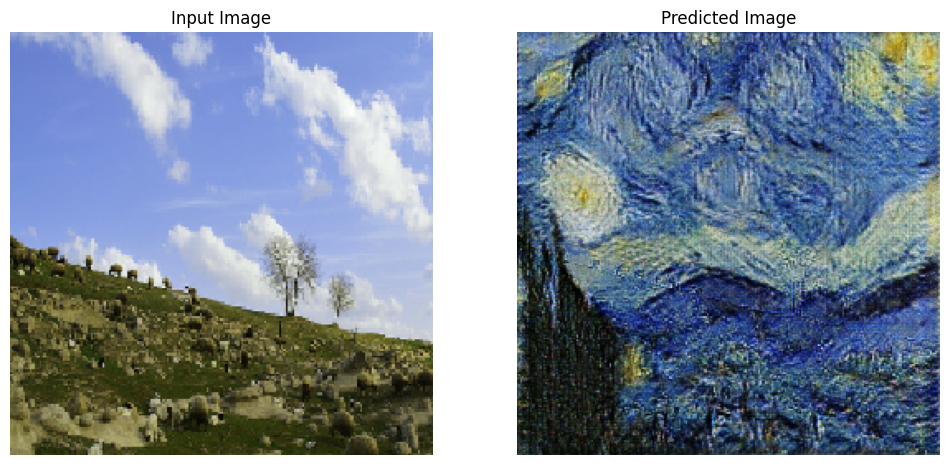

Lưu checkpoint cho epoch 3 tại ./styleTransferCheckpoints/starryNightTrain\ckpt-6
Thời gian cho epoch 3 là 16050.742929935455 giây

...............

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ẩn tất cả các cảnh báo của TensorFlow
tf.get_logger().setLevel('ERROR')  # Ẩn cảnh báo từ logger của TensorFlow

# Kiểm tra và cấu hình GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Cho phép tăng trưởng bộ nhớ
    except RuntimeError as e:
        print(e)

AUTOTUNE = tf.data.AUTOTUNE

# folder path for dataset
folder_path = "./Images/styleTransfer/"
style_path = "./Images/styleTransfer/monaLisaTrain"
photos_path = "./Images/styleTransfer/normalPhotoTrain"

#Model Parameters
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

l = ['style_jpg', 'photo_jpg'] # there are two types od image in dataset

# reading train  data from directory and leabeling them
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

# Reading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  batch_size=BATCH_SIZE)

#class names
class_names = train_ds.class_names
class_names

#Separating  styles and photos in dataset
def parse(image, label):
    return image, label

#get style image
def filter_style(image, label):
  
    return tf.equal(label[0], 0)


#get photo image
def filter_photo(image, label):
    return tf.equal(label[0], 1)

#style
style_train= train_ds.map(parse).filter(filter_style)
style_test = test_ds.map(parse).filter(filter_style)

#photo
photo_train= train_ds.map(parse).filter(filter_photo)
photo_test = test_ds.map(parse).filter(filter_photo)

#Preprocessing funcitons

#1 crop
def random_crop(image):

  cropped_image = tf.image.random_crop(
      image, size=[256, 256, 3], seed = None, name = None)

  return cropped_image


#2 normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


#3 random jitters
def random_jitter(image):
  # resizing to 360 x 360 x 3
  image = tf.image.resize(image, [360, 360],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  image = tf.squeeze(image) # Remove the "None" dimension
  


  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

# train dataset will be normalized and have random jitters
def preprocess_image_train(image, label):
  
  image = random_jitter(image)
  image = normalize(image)

  return image

# test dataset will only have normalized data
def preprocess_image_test(image, label):
  image = normalize(image)
  image = tf.squeeze(image)
  return image

style_train = style_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_train = photo_train.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

style_test= style_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_test = photo_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

sample_style = next(iter(style_train))
sample_photo = next(iter(photo_train))

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Constants and loss functions
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint and manager setup
checkpoint_path = "./styleTransferCheckpoints/monaLisaTrain"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print('Latest checkpoint restored!!')

# Function to generate images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Training step function
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

EPOCHS = 5

# Vòng lặp huấn luyện
step_count = 0  # Biến đếm bước
for epoch in range(EPOCHS):
    start_time = time.time()  # Bắt đầu đo thời gian
    n = 0

    # Kết hợp hai tập dữ liệu
    for image_x, image_y in tf.data.Dataset.zip((photo_train, style_train)):
        train_step(image_x, image_y)  # Thực hiện bước huấn luyện
        step_count += 1

        if n % 1 == 0:  # In dấu chấm mỗi bước
            print('.', end='')

        n += 1

    # Thực hiện các thao tác khác sau khi hoàn thành vòng lặp
    clear_output(wait=True)  # Xóa output cũ
    generate_images(generator_g, sample_photo)  # Tạo hình ảnh mới

    # Lưu checkpoint sau mỗi epoch
    ckpt_save_path = ckpt_manager.save()
    print('Lưu checkpoint cho epoch {} tại {}'.format(epoch + 1, ckpt_save_path))

    print('Thời gian cho epoch {} là {} giây\n'.format(epoch + 1, time.time() - start_time))



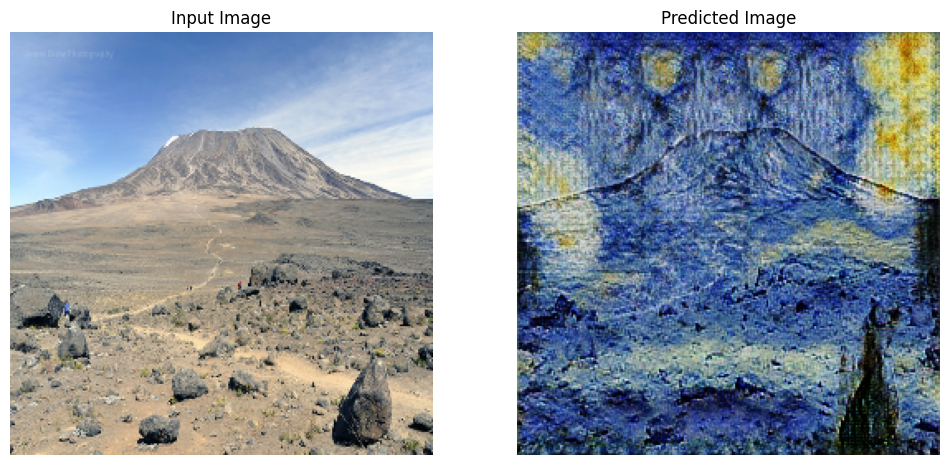

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # Allow dynamic GPU memory allocation

tf.get_logger().setLevel('ERROR')  # Suppress logging

# Checkpoint path
checkpoint_path = "./styleTransferCheckpoints/starryNightTrain"

# Create generators
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# Create checkpoint and manager
ckpt = tf.train.Checkpoint(generator_g=generator_g, generator_f=generator_f)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

specific_checkpoint_path = "./styleTransferCheckpoints/starryNightTrain/ckpt-3"  

# Restore the specific checkpoint
ckpt.restore(specific_checkpoint_path).expect_partial()

# Function to convert images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Rescale back to [0, 1]
        plt.axis('off')
    plt.show()

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Read JPG image
    original_size = tf.shape(image)[:2]  # Get original size (height, width)

    # Resize only if necessary; if your model can handle this size, keep it.
    if original_size[0] != 256 or original_size[1] != 256:
        image = tf.image.resize(image, [256, 256])  # Resize for model if needed
    
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image, original_size

# Input image path
input_image_path = './Images/normalPhotoTrain/1.jpg'

# Load and prepare the image
input_image, original_size = load_and_preprocess_image(input_image_path)
input_image = tf.expand_dims(input_image, 0)  # Add batch dimension

# Convert and resize image
generate_images(generator_g, input_image)
